In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Fixed seeds
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

NameError: name 'random' is not defined

# Processing Data

In [4]:
# Data Sets
train_df = pd.read_csv("/home/nate/machine_learning_projects/aptos_blindness_challenge/data/train/separated/train.csv")
test_df = pd.read_csv("/home/nate/machine_learning_projects/aptos_blindness_challenge/data/train/separated/test.csv")
val_df = pd.read_csv("/home/nate/machine_learning_projects/aptos_blindness_challenge/data/train/separated/val.csv")

<Figure size 432x288 with 0 Axes>

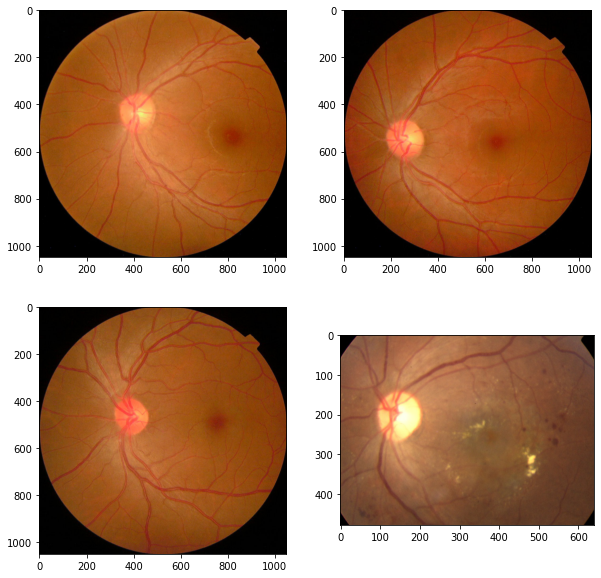

In [5]:
# Sample image read
sample_img_1 = cv2.imread(train_df.iloc[0]['paths'])[:,:,::-1]
sample_img_2 = cv2.imread(train_df.iloc[500]['paths'])[:,:,::-1]
sample_img_3 = cv2.imread(train_df.iloc[1000]['paths'])[:,:,::-1]
sample_img_4 = cv2.imread(train_df.iloc[1500]['paths'])[:,:,::-1]


plt.figure()
f, axarr = plt.subplots(2,2,figsize=(10,10))

axarr[0][0].imshow(sample_img_1)
axarr[0][1].imshow(sample_img_2)
axarr[1][0].imshow(sample_img_3)
axarr[1][1].imshow(sample_img_4)

# Data Loading

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device Used:", device)

Device Used: cuda:0


In [5]:
def load_split_train_test(traindir, valdir):
    train_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])    
    val_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])
    
    train_data = datasets.ImageFolder(traindir, transform=train_transforms)
    val_data = datasets.ImageFolder(valdir,transform=val_transforms)

    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=16)
    val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=16)
    
    return train_loader, val_loader


traindir = "/home/nate/machine_learning_projects/aptos_blindness_challenge/data/train/separated/train"
valdir = "/home/nate/machine_learning_projects/aptos_blindness_challenge/data/train/separated/val"

trainloader, valloader = load_split_train_test(traindir, valdir)

model = EfficientNet.from_pretrained('efficientnet-b0')
model.to(device)
print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [6]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
epochs = 20
log_interval = 10
save_model = True
lr = 0.01
gamma = 0.7

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(log_interval, model, device, trainloader, optimizer, epoch)
    test(model, device, valloader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/2346 (0%)]	Loss: 0.085983
Train Epoch: 1 [160/2346 (7%)]	Loss: -0.068845
Train Epoch: 1 [320/2346 (14%)]	Loss: -0.553225
Train Epoch: 1 [480/2346 (20%)]	Loss: -0.489630
Train Epoch: 1 [640/2346 (27%)]	Loss: -0.929813
Train Epoch: 1 [800/2346 (34%)]	Loss: -1.477908
Train Epoch: 1 [960/2346 (41%)]	Loss: -2.422196
Train Epoch: 1 [1120/2346 (48%)]	Loss: -3.295434
Train Epoch: 1 [1280/2346 (54%)]	Loss: -1.277306
Train Epoch: 1 [1440/2346 (61%)]	Loss: -0.166046
Train Epoch: 1 [1600/2346 (68%)]	Loss: -1.004166
Train Epoch: 1 [1760/2346 (75%)]	Loss: -1.751014
Train Epoch: 1 [1920/2346 (82%)]	Loss: -3.094540
Train Epoch: 1 [2080/2346 (88%)]	Loss: -1.816637
Train Epoch: 1 [2240/2346 (95%)]	Loss: -2.343612

Test set: Average loss: -5.2657, Accuracy: 153/733 (21%)

Train Epoch: 2 [0/2346 (0%)]	Loss: -4.121140
Train Epoch: 2 [160/2346 (7%)]	Loss: -4.911480
Train Epoch: 2 [320/2346 (14%)]	Loss: -6.163746
Train Epoch: 2 [480/2346 (20%)]	Loss: -6.710536
Train Epoch: 2 [640/2346 (27%)

Train Epoch: 11 [960/2346 (41%)]	Loss: -17.499496
Train Epoch: 11 [1120/2346 (48%)]	Loss: -17.580967
Train Epoch: 11 [1280/2346 (54%)]	Loss: -6.258406
Train Epoch: 11 [1440/2346 (61%)]	Loss: -10.183885
Train Epoch: 11 [1600/2346 (68%)]	Loss: -10.200008
Train Epoch: 11 [1760/2346 (75%)]	Loss: -9.902239
Train Epoch: 11 [1920/2346 (82%)]	Loss: -10.003398
Train Epoch: 11 [2080/2346 (88%)]	Loss: -4.939193
Train Epoch: 11 [2240/2346 (95%)]	Loss: -5.382633

Test set: Average loss: -13.6040, Accuracy: 361/733 (49%)

Train Epoch: 12 [0/2346 (0%)]	Loss: -17.275604
Train Epoch: 12 [160/2346 (7%)]	Loss: -17.634350
Train Epoch: 12 [320/2346 (14%)]	Loss: -17.433430
Train Epoch: 12 [480/2346 (20%)]	Loss: -17.513294
Train Epoch: 12 [640/2346 (27%)]	Loss: -17.535910
Train Epoch: 12 [800/2346 (34%)]	Loss: -17.487286
Train Epoch: 12 [960/2346 (41%)]	Loss: -17.588243
Train Epoch: 12 [1120/2346 (48%)]	Loss: -17.560371
Train Epoch: 12 [1280/2346 (54%)]	Loss: -6.397774
Train Epoch: 12 [1440/2346 (61%)]	Loss: